# POLI SCI 3

# Week 7, Lecture Notebook 1: *p*-values in Experiments

In this lecture, we're going to bring together the ideas from Week 6: the idea of noise in experiments and the idea of $p$-values.

Here's how. In brief:
- In experiments, the null hypothesis is almost always that the treatment has no effect relative to the baseline (so, no has no effect relative to control; or, is equally effective to another treatment).
- When we do experiments, we usually want to show that the null hypothesis is wrong (i.e., that skeptics who think the treatment didn't have an effect are wrong).
- When we analyze an experiment, we reach an estimate of what the true treatment effect is.
- When we analyze an experiment, we calculate a standard error, which gives us a measure of how likely we would see different estimates by chance if there were no effect.

Putting these ideas together, the way we show that treatments probably had an effect is an experiment is:
- Comparing the actual estimate from the experiment to what might have occurred by chance if the null hypothesis were true.

In today's notebook, I'll show you an example of this using the social lobbying data we started looking at last week.

## Data

Again, let's use the dataset from the social lobbying experiment.

In [1]:
library(estimatr)

data <- read.csv('ps3_lobbying.csv')
head(data)

,caseid,supportgroup,treat,ally,female
,<int>,<int>,<chr>,<dbl>,<int>
1,36,0,control,0.3333333,0
2,64,0,control,0.3333333,0
3,56,0,control,0.3333333,0
4,96,0,control,0.0000000,0
5,101,0,control,0.0000000,0
6,82,0,control,0.0000000,1


Here is a quick reminder of what each column means:

- `caseid`: Number that identifies each legislator/district
- `supportgroup`: This is the *outcome*. It is a measure of whether the legislator agreed to list their name publicly as a "sponsor" of the bill.
- `treat`: This is the *treatment*. It has several possible values:
    - `"control"`: the office received no contact from the lobbyist
    - `"officelobby"`: the legislator was asked to meet to discuss the bill in their office
    - `"sociallobby"`: the legislator was asked to meet to discuss the bill at a social location (a restaurant or bar)
- `ally`: The authors thought that social lobbying might be especially effective among legislators who had supported the group's priorities in the past. To measure this, they asked the lobbyist: "In your opinion, how well does the phrase ‘ally of the interest group’ describe the legislator?" This is therefore the lobbyists' rating of whether the legislator is an ally of the interest group (values 0, 1/3, 2/3, and 1).
- `female` : legislator gender, 1 = legislator is female; 0 = not

Again, here is what `treat` looks like:

In [2]:
table(data$treat)


    control officelobby sociallobby 
         38          40          41 

And here was our estimate of the effect of social lobbying:

In [3]:
difference_in_means(supportgroup ~ treat, data, condition1 = 'control', condition2 = 'sociallobby')

Design:  Standard 
                  Estimate Std. Error  t value  Pr(>|t|)    CI Lower  CI Upper
treatsociallobby 0.1161746 0.07675608 1.513555 0.1345858 -0.03687757 0.2692267
                       DF
treatsociallobby 70.86971

## What would skeptical Sarah say?

As I mentioned last week, $p$-values start by imagining a skeptic. Let's call her Sarah.

Whenever we analyze an experiment, we imagine a skeptic who thinks the treatment we are analyzing the effects of had no effect. That's the null hypothesis in an experiment: the treatment had no effect. We want to show the skeptic that they're wrong.

For example, returning to the social lobbying example, Sarah thinks that social lobbying doesn't work. She sees the fact that we estimated a 0.116 effect. But she reminds us: "In experiments, we can see positive estimates even if the true average treatment effect is zero! You might have just randomly put the legislators who supported the bill anyway into the social lobbying group!"

But, *how likely is it* that we would have seen an estimate *this* large if Sarah were right (i.e., that the null hypothesis we're trying to disprove were right)? This is what a *p*-value tells us.

### Let's put ourselves in Sarah's shoes

To answer our skeptic Sarah, we put ourselves in her shoes and approach the data as if she were right.

Sarah thinks all the potential outcomes in this study are equal for a given person: whether a legislator is assigned to office lobbying, the control group, or social lobbying, their outcome would be the same. She thinks the only reason we're seeing the social lobbying group be more supportive of the bill is that we "got lucky": we happened to put the people more supportive of the bill in the social lobbying group by random chance. After all, we were randomizing! We call what Sarah thinks **the null hypothesis**.

The way we're going to answer Sarah is by first *assuming she is right* -- that is, that the treatment has no effect -- and then *seeing how likely it is we'd get the estimate we did if she were right*.

In Sarah's world, we can just take our data, re-randomize or "shuffle" it, and see how big the estimate is. Sarah expects to say: "see, told you so, you often get estimates just as big!"

To do this, I'll start by doing what I did in lecture earlier this week again. Again, **you don't need to be able to code this yourself, but I do want you to understand what I'm doing.**

In [11]:
# Function to re-randomize, or "shuffle", the treatment variable
re.randomize <- function(input.data) {
    input.data$treat <- sample(input.data$treat)
    return(input.data)
}
head(re.randomize(data))

,caseid,supportgroup,treat,ally,female
,<int>,<int>,<chr>,<dbl>,<int>
1,36,0,control,0.3333333,0
2,64,0,officelobby,0.3333333,0
3,56,0,sociallobby,0.3333333,0
4,96,0,control,0.0000000,0
5,101,0,officelobby,0.0000000,0
6,82,0,sociallobby,0.0000000,1


In [12]:
# Function to compute the effect of social lobbying
compute.social.lobby.effect <- function(input.data) {
    estimate <- difference_in_means(supportgroup ~ treat, input.data,
                                    condition1 = 'control', condition2 = 'sociallobby')$coefficients
    return(as.numeric(estimate))
}

actual.estimate <- compute.social.lobby.effect(data)
actual.estimate

[1] 0.1161746

In [13]:
compute.social.lobby.effect(re.randomize(data))
compute.social.lobby.effect(re.randomize(data))
compute.social.lobby.effect(re.randomize(data))

[1] 0.06739409

[1] -0.1129653

[1] -0.05840822

The answer bounces around every time we run this function. This is what Sarah thinks we did in this experiment -- we took some data, randomly shuffled it into groups, and then looked at the outcomes. She thinks what we actually did to the people randomized into the social lobbying group didn't matter.

Let's do this 50,000 times and store the results of all 50,000 times.

In [14]:
simulations <- replicate(50000, compute.social.lobby.effect(re.randomize(data)))
head(simulations)

[1] -0.03401797  0.06739409 -0.03401797  0.04107831 -0.06225931 -0.11103979

We can look at all 50,000 visually:

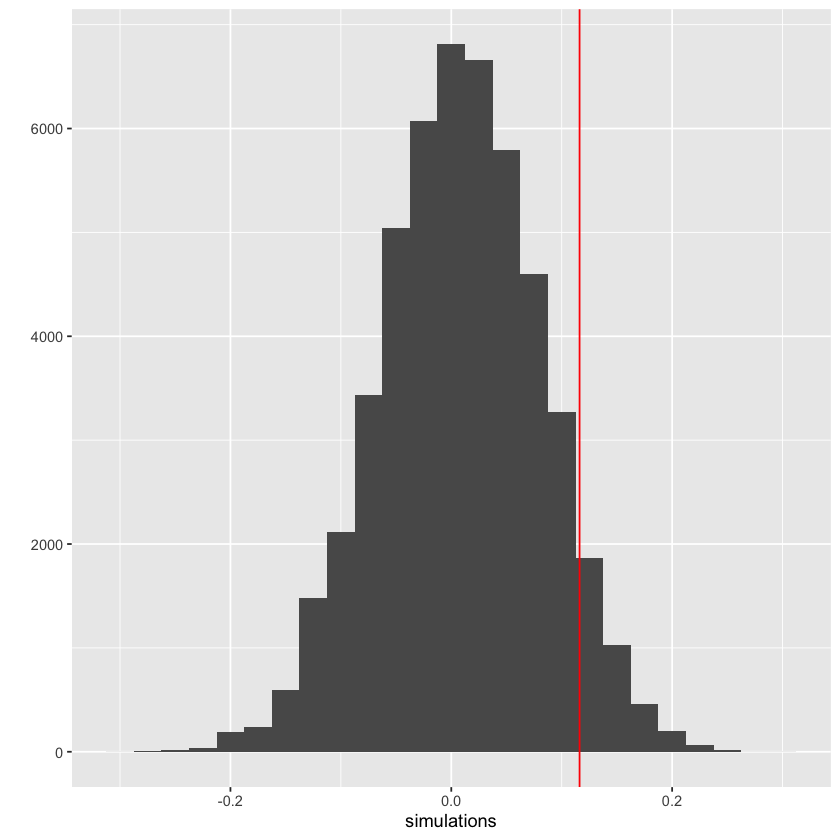

In [15]:
library(ggplot2)
qplot(simulations, binwidth = .025) + geom_vline(xintercept = actual.estimate, color = 'red')

The red line is the actual estimate in Grose et al.'s study. And **the standard error is the width of this distribution of what could have happened by chance**.

It looks like there's a decent number of simulations where, just by randomly reshuffling which observations we pretend are in the social lobbying treatment and which are in control, we see an estimate as large or larger than the estimate Grose et al. found.

"See, that's what I meant!", Sarah says. And she has a point. 😒

How common is this exactly? This next graph shows you all the simulations where the estimate was at least as large in blue.

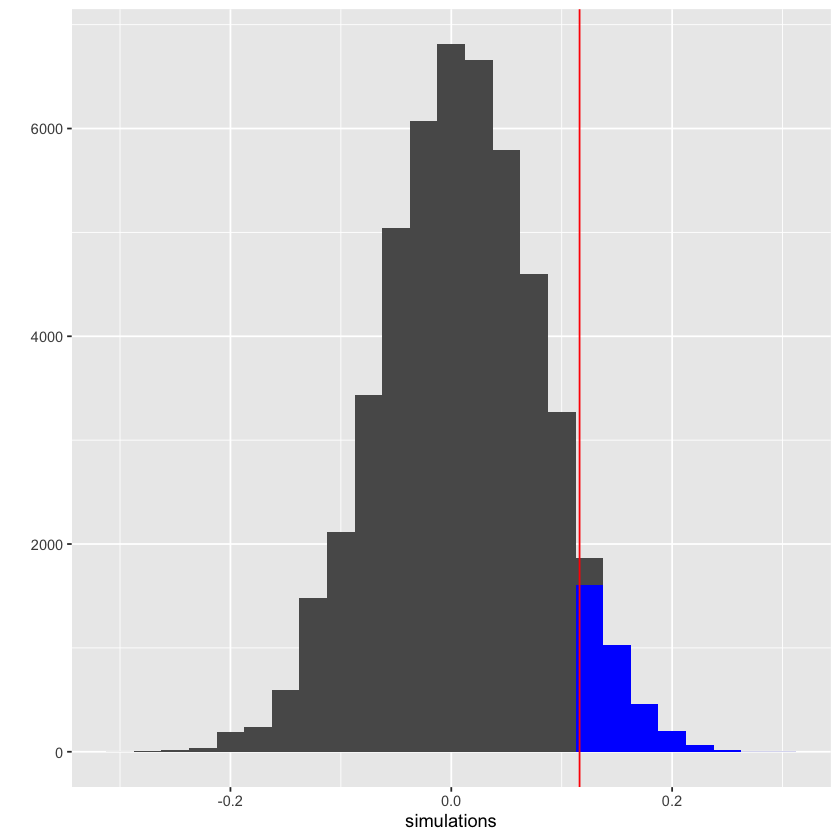

In [16]:
simulations.at.least.as.large <- subset(simulations, simulations > actual.estimate)
qplot(simulations, binwidth = .025) + geom_histogram(data = data.frame(x=simulations.at.least.as.large), aes(x=x), fill="blue", binwidth = .025) + geom_vline(xintercept = actual.estimate, color = 'red')

Let's count them:

In [17]:
length(simulations.at.least.as.large)

[1] 3378

In [18]:
length(simulations)

[1] 50000

In [19]:
length(simulations.at.least.as.large) / length(simulations)

[1] 0.06756

This is our first *p*-value in an experiment!

Here's what this *p*-value means: **_if the treatment actually had no effect_, there is only a ~6.8% chance that we'd see an estimate this large or larger**. That is, if our skeptic Sarah were right, there's only a 6.8% chance we'd see what we saw. It's not impossible, but it's not all that likely.

## Revisiting interpretations of $p$-values

In experiments, a statistically significant $p$-value ($p < 0.05$) means, **by arbitrary convention**, that we call the null hypothesis "rejected". Since the null hypothesis in experiments is that the treatment had no effect, this means we reject that the treatment had no effect if the $p$-value is $< 0.05$.

But, to revisit what I said last week:

#### A significant $p$-value doesn't mean the null hypothesis is _actually_ false

Another way of thinking about what a _p_-value tells us: if we repeated the experiment many times, what percent of the time would we get an estimate this large if the treatment had no effect.

For example, suppose 20 different groups in the class did a final project looking at whether eating jelly beans causes acne. Even if there is no effect of jelly bean eating on acne, we'd expect 1 out of the 20 groups to get a result with a *p*-value less than 0.05 merely by chance.

xkcd is helpful again here:

<img src="significant.png" width="40%" height="auto">

The important point here is that, even if the null hypothesis is true (the treatment has no effect), we might see a p-value less than 0.05. In fact, we expect this to happen around 5% of the time we run experiments.

#### A non-significant $p$-value doesn't mean the null hypothesis is true

Just like a statistically significant result doesn't necessarily mean the null hypothesis is false/the treatment has an effect, failing to find a statistically significant result doesn't mean the treatment has no effect.

For example, an experiment might have a really small sample size, meaning **the standard error might be too big**. In this case, even a reasonably large treatment effect would be impossible to definitively distinguish from noise, and so we would have a large (non-significant) $p$-value. This doesn't mean the treatment has no effect. It just means we can't tell Sarah she's wrong.

If you think a treatment has an effect and get a non-significant p-value, you don't need to abondon your beliefs. But Sarah is going to keep thinking the treatment has no effect; you can't show her much, either. An experiment with a non-significant p-value is simply *inconclusive*.

#### Don't despair. An estimate is still our best guess.

I can see this being frustrating. And yes, it *is* frustrating to get results from an experiment back when your estimate *suggests* your teatment might have an effect --- and yes, a skeptic can still say "but there's a decent chance that you could have seen this estimate by chance."

Often, data just isn't fully conclusive. That's life.

However, just because an experiment doesn't establish that a treatment works beyond all reasonable doubt doesn't mean it tells us nothing.

When we get results from experiments with insignificant p-values, a reasonable response is: "If you're skeptical this treatment has an effect, I can't prove you wrong. It might not do anything. However, my best guess is that it does."

Sometimes in life we have to make decisions, and **an insignificant p-value does not mean a treatment doesn't work**. An estimate is still our best guess, even if the evidence the treatment effect differs from zero isn't that strong.

## Reviewing Concepts/Terms

- **_p_-value**: The probability we would see an estimate as large or larger as the one we did, *if* a skeptic were correct that the treatment had no effect.
    - Does *not* measure the probability the treatment has no effect.
    - Does *not* measure the probability the treatment has an effect.
    - Helps answer a skeptic of a treatment by telling them how likely it is we would see the effect _estimate_ we did if the treatment actually had no effect.
- **Statistical significance**: A _p_-value less than 0.05. This is an arbitrary threshold social scientists have agreed upon to decide that there is strong statistical evidence that a treatment has an effect.
    - **If you have a significant _p_-value**: this does not mean the treatment *definitely* has an effect. It's possible--indeed there's a 5% chance--of getting a statistically significant result even if a treatment has no effect. However, by convention, we decide to simply call the skeptic disproved at this point, even though the skeptic's perspective still is possible.
    - **If you have an insignificant _p_-value**: this does *not* mean that the treatment *definitely does not* have an effect. For example, a treatment might have an effect but the sample size of an experiment might be too small (i.e., the standard error might be too large/wide) for the experiment to demonstrate the effect is due to chance. **The estimate is still our best guess, even if we can't disprove a skeptic either.**

If you're still having trouble with $p$-values, I recommend <a href="https://medium.com/@timothyguang/can-you-explain-the-p-value-to-your-grandmother-heres-an-intuitive-explanation-f64e6c0ecffb" target="_blank">this blog post</a>.